In [3]:
%load_ext autoreload
%autoreload 2
    
import os
import sys

import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
src_dir = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), 'src')
sys.path.append(src_dir)

from dataset import find_unique_element
from atomizer import text_to_sentences


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def load_dataset_from_file(dataset = None, filepath = None, cache_path = "/Users/cherian/Projects/conformal-safety/.cache"):
    if dataset is not None:
        with open(f"{cache_path}/{dataset}_responses.pkl", 'rb') as fp:
            res_cache = pickle.load(fp)
        with open(f"{cache_path}/{dataset}_parsed.pkl", 'rb') as fp:
            af_cache = pickle.load(fp)
        with open(f"{cache_path}/{dataset}_scored.pkl", 'rb') as fp:
            ann_cache = pickle.load(fp)
            
        prompts = []
        messages = []
        for key, val in res_cache.items():
            prompts.append(key[:-2])
            messages.append(val[0]['message'])

        dataset = [
            {
                'prompt': key[:-2],
                'response': val[0]['message'],
                'atomic_facts': []
            }
            for key, val in res_cache.items()
        ]
        idx_guess = 0
        atomic_facts = [[] for _ in range(len(messages))]
        for k in af_cache.keys():
            atomized_msg = af_cache[k][0]['message']
            atomized_facts = text_to_sentences(atomized_msg)
            sentence = k.split('\n')[-1].split('facts:')[-1].strip()[:-2]
            cur_idx = find_unique_element(messages, lambda x: sentence in x, approx_index=idx_guess)
            if cur_idx is None:
                raise ValueError("Should regenerate responses and atomic facts I guess because they don't match :(")
            idx_guess = cur_idx
            atomic_facts[cur_idx].extend(atomized_facts)
        
        idx_guess = 0
        for key, val in ann_cache.items():
            af, _ = key.split("Input: ")[-1].split("True or False?\nOutput:_")
            af = af.strip()
            ann = bool(val[0]['message'])
            
            cur_idx = find_unique_element(atomic_facts, lambda x: af in x, approx_index=idx_guess)
            if cur_idx is None:
                if af.startswith("He retired with a career record of"): # special case because of some crazy pickle bug??
                    cur_idx = idx_guess
                else:
                    raise ValueError("Huh weird...probably should have failed in the last cache recovery step.")
            dataset[cur_idx]['atomic_facts'].append(
                {'atom': af, 'is_supported': ann}
            )
            idx_guess = cur_idx
    elif filepath is not None:
        with open(filepath, 'rb') as fp:
            dataset = pickle.load(fp)
    else:
        raise ValueError("No dataset to load.")
    return dataset

def load_features(dataset = None, filepath = None, cache_path = "/Users/cherian/Projects/conformal-safety/.cache"):
    if dataset is not None:
        with open(f"{cache_path}/{dataset}_frequency.pkl", 'rb') as fp:
            freq_cache = pickle.load(fp)
        with open(f"{cache_path}/{dataset}_self_evals.pkl", 'rb') as fp:
            eval_cache = pickle.load(fp)
        return freq_cache, eval_cache

In [5]:
dataset_name = "factscore_final"
data_path = "/Users/cherian/Projects/conformal-safety/data"
dataset_path = f"{data_path}/factscore_final_dataset.pkl"
freq_path = f"{data_path}/factscore_final_frequencies_2.npz"
selfevals_path = f"{data_path}/factscore_final_self_evals.npz"
metadata_path = f"{data_path}/factscore_final.csv"

dataset = load_dataset_from_file(filepath=dataset_path)
frequencies = np.load(freq_path)
selfevals = np.load(selfevals_path)
metadata = pd.read_csv(metadata_path, index_col=0).reset_index(drop=True).drop_duplicates()
## need to filter the dataset so that all information is available for every data point

drop_prompts = []
for k in frequencies:
    if frequencies[k].ndim != 1:
        drop_prompts.append(k)
    elif np.allclose(selfevals[k], -1):
        drop_prompts.append(k)

# drop and match ordering of dataset
dataset = [dat for dat in dataset if dat['prompt'] not in drop_prompts]

prompts_to_keep = [dat['prompt'] for dat in dataset]
names_to_keep = [p.split('about')[-1].strip()[:-1] for p in prompts_to_keep]

metadata = metadata.set_index("Name")
metadata = metadata.loc[names_to_keep].reset_index()

frequencies_arr = [frequencies[p] for p in prompts_to_keep]
selfevals_arr = [selfevals[p] for p in prompts_to_keep]
annotations_arr = [np.asarray([af["is_supported"] for af in dat["atomic_facts"]]) for dat in dataset]


print(len(frequencies_arr), len(selfevals_arr), len(metadata), len(dataset), len(annotations_arr))

8474 8474 8474 8474 8474


In [7]:
metadata.loc[663, "count_bins"] = "Very Rare"
metadata.loc[663, "max_counts"] = 0


In [8]:
from typing import List
from conditionalconformal import CondConf

def split_dataset(dataset, rng, train_frac = 0.8):
    x, y = dataset
    ind = np.arange(len(x))
    rng.shuffle(ind)
    train_num = int(train_frac * len(x))
    train_ind = ind[0:train_num]
    calib_ind = ind[train_num:]

    x_train = [x[i] for i in train_ind]
    y_train = [y[i] for i in train_ind]

    x_calib = [x[i] for i in calib_ind]
    y_calib = [y[i] for i in calib_ind]
    return (x_train, y_train), (x_calib, y_calib), train_ind, calib_ind
    
def score_func(
    claim_scores : List[np.ndarray],
    annotations : List[np.ndarray],
    method : str = "max"
):
    if method == "max":
        min_score = -1
        scores = np.zeros((len(claim_scores),))
        for i, (cs, a) in enumerate(zip(claim_scores, annotations)):
            scores[i] = np.max(cs[~a]) if np.sum(~a) >= 1 else min_score
    if isinstance(method, int):
        min_score = -1
        scores = np.zeros((len(claim_scores),))
        for i, (cs, a) in enumerate(zip(claim_scores, annotations)):
            scores[i] = np.sort(cs[~a])[::-1][method] if np.sum(~a) > method else min_score
    return scores

def split_threshold(
    conf_scores : np.ndarray,
    quantile
):
    n = len(conf_scores)
    threshold = np.sort(conf_scores)[int(np.ceil(quantile * (n + 1)))]
    return threshold

def get_retained_claims(claim_scores, thresholds):
    claims_retained = []
    for cs, t in zip(claim_scores, thresholds):
        claims_retained.append(np.mean(cs > t))
    return claims_retained

def get_validity(claim_scores, annotations, threshold, method):
    conf_scores = score_func(claim_scores, annotations, method)
    validity = conf_scores <= threshold
    return validity

def run_split_conformal(x_arr, y_arr, method, quantile):
    conf_scores = score_func(x_arr, y_arr, method=k)
    threshold = split_threshold(conf_scores, quantile)
    return conf_scores, threshold
    


In [9]:
ordinal_arr = [np.arange(len(f)) for f in frequencies_arr]

rng = np.random.default_rng(seed=0)
rand_scores = rng.standard_normal(size=(len(np.concatenate(selfevals_arr)),))

print(np.corrcoef(np.concatenate(frequencies_arr), np.concatenate(annotations_arr)))
print(np.corrcoef(np.concatenate(selfevals_arr), np.concatenate(annotations_arr)))
print(np.corrcoef(np.concatenate(ordinal_arr), np.concatenate(annotations_arr)))
print(np.corrcoef(rand_scores, np.concatenate(annotations_arr)))

[[1.         0.37656178]
 [0.37656178 1.        ]]
[[1.         0.16207942]
 [0.16207942 1.        ]]
[[ 1.         -0.00960692]
 [-0.00960692  1.        ]]
[[ 1.         -0.00251182]
 [-0.00251182  1.        ]]


In [441]:
continent_dummies = pd.get_dummies(metadata["continent"])
freq_dummies = pd.get_dummies(metadata["count_bins"])
freq_dummies = freq_dummies[["Very Frequent", "Frequent", "Medium", "Rare", "Very Rare"]]
continent_names = continent_dummies.columns
freq_names = freq_dummies.columns

def run_coverage_trial(x_arr, y_arr, z_arr, rng, method, quantile):
    data_calib, data_test, idx_calib, idx_test = split_dataset((x_arr, y_arr), rng, train_frac=0.7)
    scores_calib = score_func(*data_calib, method=method)
    scores_test = score_func(*data_test, method=method)
    
    condconf = CondConf(lambda x,y: y, lambda x: x)
    condconf.setup_problem(z_arr[idx_calib], scores_calib)
    
    # scores, threshold = run_split_conformal(*data_calib, method=method, quantile=quantile)
    valid_inds = []
    claim_perc = []
    for i, j in enumerate(idx_test):
        try:
            threshold = condconf.predict(quantile, z_arr[j].reshape(1,-1), lambda c, x: c, randomize=True)
        except:
            threshold = [np.inf]
        valid_inds.append(threshold >= scores_test[i])
        claim_perc.append(get_retained_claims([data_test[0][i]], threshold)[0])
                          
    valid_inds = np.asarray(valid_inds).flatten()
    claim_perc = np.asarray(claim_perc).flatten()

    # valid_inds = get_validity(*data_calib, threshold, method)
    all_covs = np.zeros((1,))
    marginal_cov = np.mean(valid_inds)
    all_covs[0] = marginal_cov

    all_claims = np.zeros((1,))
    all_claims[0] = np.mean(claim_perc)

    continent_covs = np.zeros(len(continent_names))
    continent_claims = np.zeros(len(continent_names))

    for c_idx in range(len(continent_names)):
        continent_cov = np.sum(continent_dummies.to_numpy()[idx_test,c_idx] * valid_inds) / np.sum(continent_dummies.to_numpy()[idx_test,c_idx])
        continent_covs[c_idx] = continent_cov
        continent_perc = np.sum(continent_dummies.to_numpy()[idx_test,c_idx] * claim_perc) / np.sum(continent_dummies.to_numpy()[idx_test,c_idx])
        continent_claims[c_idx] = continent_perc
        
    freq_covs = np.zeros(len(freq_names))
    freq_claims = np.zeros(len(freq_names))
    for f_idx in range(len(freq_names)):
        freq_cov = np.sum(freq_dummies.to_numpy()[idx_test,f_idx] * valid_inds) / np.sum(freq_dummies.to_numpy()[idx_test,f_idx])
        freq_covs[f_idx] = freq_cov
        freq_perc = np.sum(freq_dummies.to_numpy()[idx_test,f_idx] * claim_perc) / np.sum(freq_dummies.to_numpy()[idx_test,f_idx])
        freq_claims[f_idx] = freq_perc
    
    return np.concatenate((all_covs, continent_covs, freq_covs)), np.concatenate((all_claims, continent_claims, freq_claims))

# selfevals_arr another option
n_trials = 50
all_covs = np.zeros((n_trials, 1 + len(continent_names) + len(freq_names)))
all_claims = np.zeros((n_trials, 1 + len(continent_names) + len(freq_names)))

rng = np.random.default_rng(seed=0)
k = 3
quantile = 0.9
method = "frequency"

z_ones = np.ones((len(frequencies_arr), 1))
views = metadata["max_counts"].to_numpy()
views += 1
z_views = views.clip(0, np.quantile(views, 0.95)).reshape(-1,1)
z_views = z_views / np.mean(z_views)
z_dummies = freq_dummies.to_numpy().astype(int)
z_freq = np.asarray([freq.std() for freq in frequencies_arr]).reshape(-1,1)
z_se = np.asarray([se.std() for se in selfevals_arr]).reshape(-1,1)
z_arr = np.concatenate((z_ones, z_views, z_views**2, z_views**3), axis=1)
z_arr = z_dummies
frequencies_arr_jitter = [freq + rng.uniform(low=0, high=1e-3, size=freq.shape) for freq in frequencies_arr]
rng = np.random.default_rng(seed=1)
for trial in tqdm(range(n_trials)):
    all_covs[trial], all_claims[trial] = run_coverage_trial(frequencies_arr_jitter, annotations_arr, z_arr, rng, k, quantile)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:38<00:00,  3.17s/it]


In [13]:
n_trials = 50
all_covs_mh = np.zeros((n_trials, 1 + len(continent_names) + len(freq_names)))
all_claims_mh = np.zeros((n_trials, 1 + len(continent_names) + len(freq_names)))

rng = np.random.default_rng(seed=0)
k = 3
quantile = 0.9
method = "frequency"

z_ones = np.ones((len(frequencies_arr), 1))
views = metadata["max_counts"].to_numpy()
views += 1
z_views = views.clip(0, np.quantile(views, 0.95)).reshape(-1,1)
z_views = z_views / np.mean(z_views)
z_dummies = freq_dummies.to_numpy().astype(int)
z_freq = np.asarray([freq.std() for freq in frequencies_arr]).reshape(-1,1)
z_se = np.asarray([se.std() for se in selfevals_arr]).reshape(-1,1)
# z_arr = np.concatenate((z_ones, z_views, z_views**2, z_views**3), axis=1)
z_arr = z_ones
frequencies_arr_jitter = [freq + rng.uniform(low=0, high=1e-3, size=freq.shape) for freq in frequencies_arr]
rng = np.random.default_rng(seed=1)
for trial in tqdm(range(n_trials)):
    all_covs_mh[trial], all_claims_mh[trial] = run_coverage_trial(frequencies_arr_jitter, annotations_arr, z_arr, rng, k, quantile)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:01<00:00,  2.42s/it]


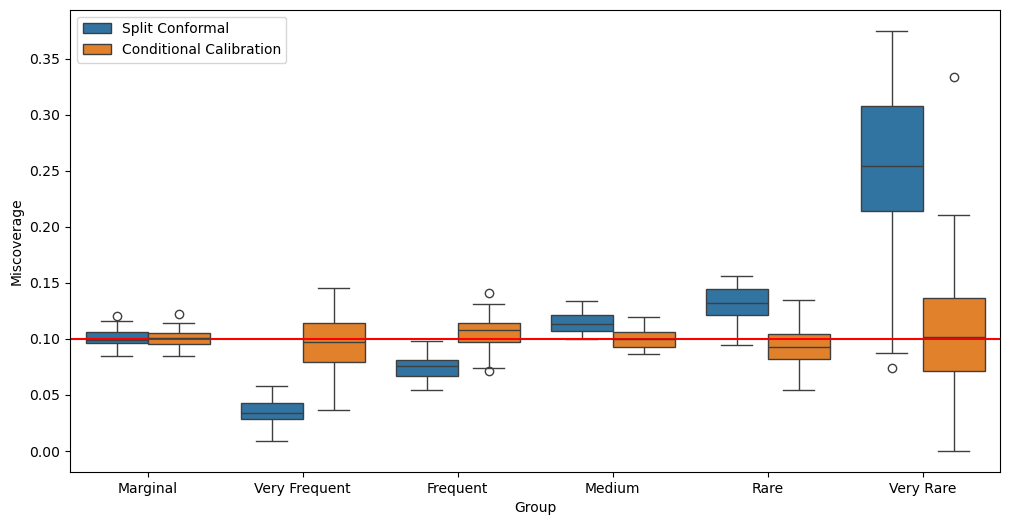

In [436]:
# Create a DataFrame for each method
names = ["Marginal"] + continent_names.tolist() + freq_names.tolist()
indices_to_plot = [0, -5, -4, -3, -2, -1]

names = [names[i] for i in indices_to_plot]
df1 = pd.DataFrame(1 - all_covs_mh[:,indices_to_plot], columns=names)
df2 = pd.DataFrame(1 - all_covs[:,indices_to_plot], columns=names)

# Add a column to identify the method
df1['Method'] = 'Split Conformal'
df2['Method'] = 'Conditional Calibration'

# Combine the DataFrames
df = pd.concat([df1, df2])

# Melt the combined DataFrame
df_melted = df.melt(id_vars='Method', var_name='Group', value_name='Miscoverage')

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Group', y='Miscoverage', hue='Method', data=df_melted)
plt.axhline(0.1, color='red')
# Customize the plot
plt.legend()

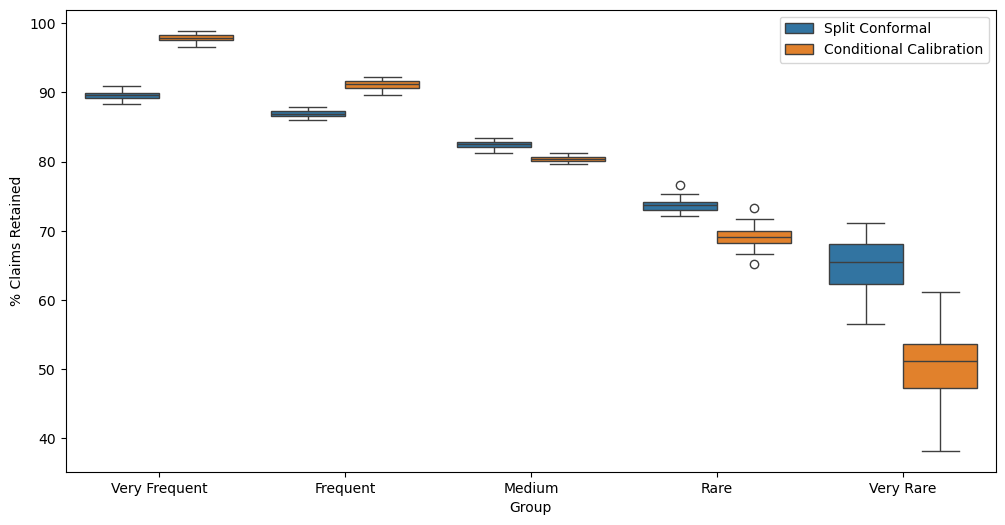

In [437]:
# Create a DataFrame for each method
names = ["Marginal"] + continent_names.tolist() + freq_names.tolist()
indices_to_plot = [-5, -4, -3, -2, -1]

names = [names[i] for i in indices_to_plot]
df1 = pd.DataFrame(all_claims_mh[:,indices_to_plot] * 100, columns=names)
df2 = pd.DataFrame(all_claims[:,indices_to_plot] * 100, columns=names)

# Add a column to identify the method
df1['Method'] = 'Split Conformal'
df2['Method'] = 'Conditional Calibration'

# Combine the DataFrames
df = pd.concat([df1, df2])

# Melt the combined DataFrame
df_melted = df.melt(id_vars='Method', var_name='Group', value_name='% Claims Retained')

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Group', y='% Claims Retained', hue='Method', data=df_melted)
# Customize the plot
plt.legend()

In [302]:
## now I should try to estimate the alpha at which the conditional conformal method retains 70% of the claims
rng = np.random.default_rng(seed=0)
k = 3

dataset = (frequencies_arr, annotations_arr)
# split dataset
data_alpha, data_conf, ind_alpha, ind_conf = split_dataset(dataset, rng, train_frac=0.1)
metadata_alpha = metadata.iloc[ind_alpha].reset_index(drop=True)
z_ones = np.ones((len(ind_alpha), 1))
views = metadata_alpha["max_counts"].to_numpy()
views += 1
z_views = views.clip(0, np.quantile(views, 0.95)).reshape(-1,1)
z_views = z_views / np.mean(z_views)
phi_alpha = lambda x: np.concatenate((np.ones((len(x), 1)), x, x**2, x**3), axis=1)

# use data alpha to estimate critical alpha for which fact retention goal is achieved
data_calib, data_test, ind_calib, ind_test = split_dataset(data_alpha, rng, train_frac=0.5)
z_calib = z_views[ind_calib]
z_test = z_views[ind_test]

scores_calib = score_func(*data_calib, method=k)

x_test, y_test = data_test
n_grid = 50
percents = np.empty((n_grid, len(x_test)))

condconf = CondConf(lambda x,y: y, phi_alpha)
condconf.setup_problem(z_calib, scores_calib)

quantile_grid = np.linspace(0.01, 0.99, 50)
i = 0
for q in tqdm(quantile_grid):
    perc_q = []
    for x_t, z_t in zip(x_test, z_test):
        cutoff = condconf.predict(quantile=q, x_test=z_t.reshape(1,-1), score_inv_fn = lambda c, x: c, randomize=True)
        perc_q.append(get_retained_claims([x_t], cutoff)[0])
    percents[i] = perc_q
    i += 1 


perc_booleans = percents >= 0.8

first_violating_indices = np.argmax(~perc_booleans, axis=0) - 1
first_violating_indices[~np.any(~perc_booleans, axis=0)] = -1  # Use -1 to indicate no False found

max_quantiles = quantile_grid[first_violating_indices]

# truncate the alpha estimate?
# max_quantiles = np.clip(max_quantiles, a_max=0.9, a_min=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:43<00:00,  1.15it/s]


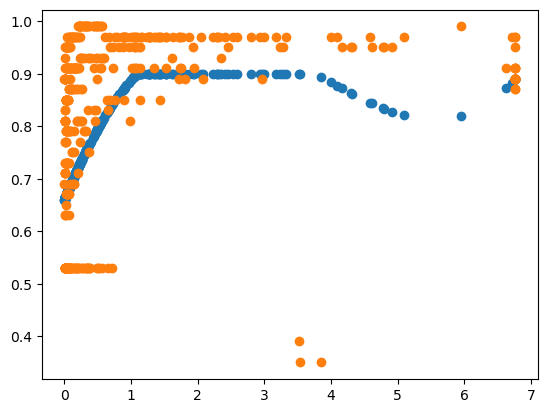

In [304]:
condconf_alpha = CondConf(score_fn = lambda x, y: y, Phi_fn = phi_alpha)
condconf_alpha.setup_problem(z_test, max_quantiles)
_, primals = condconf_alpha._get_calibration_solution(quantile=0.25)

quantile_fn = lambda x: np.clip(phi_alpha(x) @ primals, a_min=0.01, a_max=0.9)
plt.scatter(phi_alpha(z_test)[:,1], quantile_fn(z_test))
plt.scatter(phi_alpha(z_test)[:,1], max_quantiles)

In [305]:
seed = 1
nominal = []
realized = []
percents = []
zs = []

metadata_conf = metadata.iloc[ind_conf].reset_index(drop=True)
views = metadata_conf["max_counts"].to_numpy()
views += 1
z_views = views.clip(0, np.quantile(views, 0.95)).reshape(-1,1)
z_views = z_views / np.mean(z_views)

for seed in tqdm(range(2000)):
    rng = np.random.default_rng(seed=seed)
    
    data_calib, data_test, ind_calib, ind_test = split_dataset(data_conf, rng, train_frac=0.9999)
    z_calib = z_views[ind_calib]
    z_test = z_views[ind_test]
    
    x_calib, y_calib = data_calib
    scores_calib = score_func(*data_calib, method=k)
    score_fn = lambda x, y: y
    phi_fn = lambda x : np.concatenate((np.ones((len(x), 1)), x, x**2, x**3, (0.9 - quantile_fn(x)).reshape(-1,1)**2),
                                       axis=1)
    # phi_fn = lambda x : np.ones((len(x), 1))
    condconf = CondConf(score_fn = score_fn, Phi_fn = phi_fn, quantile_fn = quantile_fn)
    condconf.setup_problem(z_calib, scores_calib)
    
    x_test, y_test = data_test
    scores_test = score_func(*data_test, method=k)
    percs = []
    thresholds = []
    for x_t, z_t, s_t in zip(x_test, z_test, scores_test):
        threshold = condconf.predict(quantile=None, x_test=z_t.reshape(1,-1), score_inv_fn = lambda c, x: c, randomize=False)
        percs.append(get_retained_claims([x_t], threshold)[0])
        thresholds.append(threshold)
    realized.append([s <= t for s, t in zip(scores_test, thresholds)])
    percents.extend(percs)
    zs.append(z_test)
    nominal.append(condconf.quantile_fn(z_test))
realized = np.concatenate(realized).flatten()
nominal = np.concatenate(nominal).flatten()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:11<00:00, 10.44it/s]


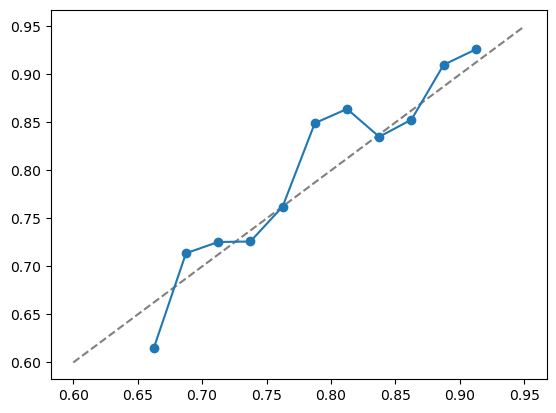

In [309]:
realized_avg = []
nominal_avg = []
nominal_std = []
for bin_left in np.linspace(0.65, .90, 11):
    ind = np.where((nominal >= bin_left) & (nominal <= bin_left + 0.025))[0]
    nominal_avg.append(bin_left + 0.0125)
    realized_avg.append(realized[ind].mean())
    nominal_std.append(1.96 * np.sqrt(nominal_avg[-1] * (1 - nominal_avg[-1]) / len(ind)))
plt.errorbar(nominal_avg, realized_avg, nominal_std, marker='o')
plt.plot(np.linspace(0.6, 0.95, 100), np.linspace(0.6, 0.95, 100), '--', color='grey')



Very Frequent
Frequent
Medium
Rare
Very Rare
0.054


Text(0, 0.5, '% Claims Retained')

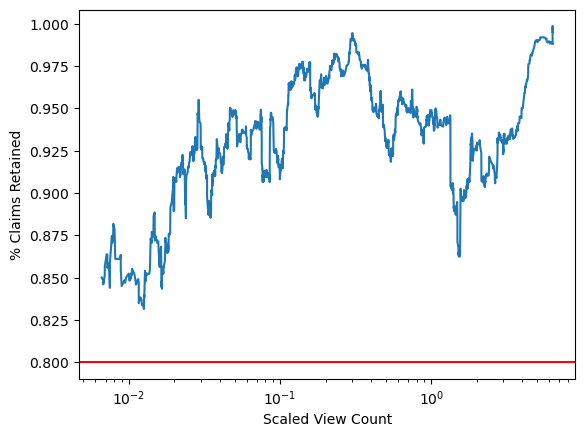

In [346]:

# whoops deleted the code that actually got the dummies...
all_dummies = np.concatenate(dummies).tolist()
freq_claims = np.zeros(len(freq_names))
z_bin_vals = []
percent_vals = []
for freq_name in freq_names:
    ind = [i for i in range(len(all_dummies)) if all_dummies[i] == freq_name]
    z_bin_vals.append(np.mean(zs[ind]))
    percent_vals.append(np.mean([percents[i] for i in ind]))
    print(freq_name)
print(np.mean(np.asarray(percents) < 0.8))

# Function to compute the moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

window_size = 50
# zs = np.concatenate(zs)
sorted_ind = np.argsort(zs)
sorted_percents = np.asarray(percents)[sorted_ind]
sorted_zs = zs[sorted_ind]
plt.plot(sorted_zs[window_size - 1:], moving_average(sorted_percents, window_size))
# plt.scatter(z_bin_vals, percent_vals, marker='x', color='red')
plt.axhline(0.8, color='red')
plt.xscale('log')
plt.xlabel("Scaled View Count")
plt.ylabel("% Claims Retained")

In [455]:
# need to boost now...
# features to boost on: frequencies_arr, selfevals_arr, ordinals_arr

import torch
from scipy.optimize import linprog

def estimate_true_error_cond(rng, q, n_eval, p, beta):
    dataset = generate_dataset(rng, n_eval, p)
    data_calib, data_test = split_dataset(dataset, rng, train_frac=0.2)
    x, y = data_calib
    x_test, y_test = data_test
    condconf = CondConf(
        score_fn = lambda x, y: np.abs(y) / np.abs(x @ beta),
        Phi_fn = lambda x: np.concatenate((np.ones((len(x), 1)), x, x**2), axis=1)
    )
    condconf.setup_problem(x, y)
    raw_cutoffs = []
    for x_t in x_test:
        raw_cutoff = condconf.predict(0.95, x_t.reshape(1,-1), score_inv_fn = lambda cutoff, x: cutoff * np.abs(x.T @ beta))
        raw_cutoffs.append(raw_cutoff)
    raw_cutoffs = np.asarray(raw_cutoffs).flatten()

    lengths = np.mean(raw_cutoffs)

    condconf = CondConf(
        score_fn = lambda x, y: np.abs(y) / np.abs(x @ beta_opt),
        Phi_fn = lambda x: np.concatenate((np.ones((len(x), 1)), x, x**2), axis=1)
    )
    condconf.setup_problem(x, y)
    raw_cutoffs = []
    for x_t in x_test:
        raw_cutoff = condconf.predict(0.95, x_t.reshape(1,-1), score_inv_fn = lambda cutoff, x: cutoff * np.abs(x.T @ beta_opt))
        raw_cutoffs.append(raw_cutoff)
    raw_cutoffs = np.asarray(raw_cutoffs).flatten()

    lengths_opt = np.mean(raw_cutoffs)
    
    return lengths, lengths_opt
    

def get_current_basis(primals, duals, Phi, S, quantile):
    interp_bools = np.logical_and(~np.isclose(duals, quantile - 1),~np.isclose(duals, quantile))
    if np.sum(interp_bools) == Phi.shape[1]:
        return interp_bools
    preds = (Phi @ primals).flatten()
    active_indices = np.where(interp_bools)[0]
    interp_indices = np.argsort(np.abs(S - preds))[0:Phi.shape[1]]
    diff_indices = np.setdiff1d(interp_indices, active_indices)
    num_missing = Phi.shape[1] - np.sum(interp_bools)
    if num_missing < len(diff_indices):
        from itertools import combinations
        for cand_indices in combinations(diff_indices, num_missing):
            cand_phi = Phi[np.concatenate((active_indices, cand_indices))]
            if np.isfinite(np.linalg.cond(cand_phi)):
                interp_bools[np.asarray(cand_indices)] = True
                break
    else:
        interp_bools[diff_indices] = True
    return interp_bools
            
def solve_qr(Phi, s, q, dtype):
    S = s.detach().numpy()
    zeros = np.zeros((Phi.shape[1],))
    bounds = [(q - 1, q)] * len(S)
    res = linprog(-1 * S, A_eq=Phi.T, b_eq=zeros, bounds=bounds,
                    method='highs-ds', options={'presolve': False})

    tau = -1 * res.eqlin.marginals

    basis = get_current_basis(tau, res.x, Phi, S, q)
    
    tau = as_tensor(np.linalg.inv(Phi[basis].T @ Phi[basis]) @ Phi[basis].T, dtype=dtype) @ s[basis]
    return tau.reshape(-1,1)

def as_tensor(x, dtype, requires_grad=False):
    return torch.tensor(x, dtype=dtype, requires_grad=requires_grad)
    
def cond_score_length(beta, dataset, metadata, rng, q=0.9):
    data_train, data_calib, ind_train, ind_calib = split_dataset(dataset, rng)
    x_train, y_train = data_train
    x_calib, y_calib = data_calib

    views = metadata["max_counts"].to_numpy()
    views += 1
    z_views = views.clip(0, np.quantile(views, 0.95)).reshape(-1,1)
    z_views = z_views / np.mean(z_views)
    z_dummies = freq_dummies.to_numpy().astype(int)

    z_arr = z_views
    z_arr = z_dummies 
    z_train = z_arr[ind_train]
    z_calib = z_arr[ind_calib]
    
    scores_train = torch_score_func(x_train, y_train, beta, method=3)

    Phi_fn = lambda x: np.concatenate((np.ones((len(x), 1)), x, x**2, x**3), axis=1)
    Phi_fn = lambda x : x
    
    # replace cutoff computation with quantile regression
    phi_train = Phi_fn(z_train)
    try:
        tau = solve_qr(phi_train, scores_train, q, beta.dtype)
    except:
        print("gradient broke")
        tau = torch.zeros((phi_train.shape[1],), dtype=beta.dtype)

    phi_calib = Phi_fn(z_calib)
    cutoffs = torch.flatten(as_tensor(phi_calib, dtype=beta.dtype) @ tau)

    total = torch.zeros(1, requires_grad=True)
    for x_c, cutoff in zip(x_calib, cutoffs):
        perc = torch.sigmoid((cutoff - torch.abs(torch.as_tensor(x_c, dtype=beta.dtype) @ beta)))
        total = total + torch.mean(perc) / len(cutoffs)

    return total, (x_calib, cutoffs), tau

def torch_score_func(features, annotations, beta, method):
    scores = as_tensor(np.zeros((len(features),)), dtype=beta.dtype)
    for i, (f, a) in enumerate(zip(features, annotations)):
        cs = torch.abs(as_tensor(f, dtype=beta.dtype) @ beta)
        at = as_tensor(a, dtype=bool)
        scores[i] = torch.sort(cs[~at], descending=True)[0][method] if torch.sum(~at) > method else -1
    return scores
    
rng = np.random.default_rng(seed=0)
z_feat_arr = [z * np.ones_like(f_arr) for z, f_arr in zip(z_views, frequencies_arr)]
features_arr = [np.concatenate((f_arr.reshape(-1,1), s_arr.reshape(-1,1), o_arr.reshape(-1,1) / o_arr.max(),
                               z_arr.reshape(-1,1)), axis=1)
                for f_arr, s_arr, o_arr, z_arr in zip(frequencies_arr, selfevals_arr, ordinal_arr, z_feat_arr)]

dataset = (features_arr, annotations_arr)
# split dataset
data_alpha, data_conf, ind_alpha, ind_conf = split_dataset(dataset, rng, train_frac=0.1)
metadata_alpha = metadata.iloc[ind_alpha].reset_index(drop=True)


beta_cond = torch.tensor(np.asarray([1,0,0,0]), dtype=torch.float, requires_grad=True)
print(beta_cond)
optimizer = torch.optim.Adam([beta_cond])

obj_percs = []
# true_lengths = []
# n_eval = 1000
for i in tqdm(range(1000)):
    optimizer.zero_grad()
    perc, (x_calib, cutoffs), tau = cond_score_length(beta_cond, data_alpha, metadata_alpha, rng)
    perc.backward()
    optimizer.step()
    obj_percs.append(perc.detach())
    if i % 1000 == 0:
        # true_error, true_error_baseline = estimate_true_error_cond(rng, 0.95, n_eval, p, beta_cond.detach().numpy())
        # print(f"iteration {i}", true_error - true_error_baseline)
        # true_lengths.append(true_error - true_error_baseline)
        print(obj_percs[-1], beta_cond, beta_cond.grad)
print(beta_cond, perc)

tensor([1., 0., 0., 0.], requires_grad=True)


  0%|▏                                                                                                                         | 2/1000 [00:00<01:31, 10.96it/s]

tensor([0.4414]) tensor([ 1.0010e+00, -1.0000e-03, -1.0000e-03,  1.0000e-03],
       requires_grad=True) tensor([-0.0574,  0.0172,  0.0220, -0.1297])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:26<00:00, 11.59it/s]

tensor([ 1.9152,  0.1907, -0.0641,  0.4019], requires_grad=True) tensor([0.3716], grad_fn=<AddBackward0>)


In [456]:
scores_arr = [f @ beta_cond.detach().numpy() for f in features_arr]

n_trials = 50
all_covs_jc = np.zeros((n_trials, 1 + len(continent_names) + len(freq_names)))
all_claims_jc = np.zeros((n_trials, 1 + len(continent_names) + len(freq_names)))

rng = np.random.default_rng(seed=0)
k = 3
quantile = 0.9

z_ones = np.ones((len(frequencies_arr), 1))
views = metadata["max_counts"].to_numpy()
views += 1
z_views = views.clip(0, np.quantile(views, 0.95)).reshape(-1,1)
z_views = z_views / np.mean(z_views)
z_dummies = freq_dummies.to_numpy().astype(int)
z_freq = np.asarray([freq.std() for freq in frequencies_arr]).reshape(-1,1)
z_se = np.asarray([se.std() for se in selfevals_arr]).reshape(-1,1)
z_arr = np.concatenate((z_ones, z_views, z_views**2, z_views**3), axis=1)
z_arr = z_dummies
scores_arr_jitter = [score + rng.uniform(low=0, high=1e-3, size=score.shape) for score in scores_arr]
rng = np.random.default_rng(seed=1)
for trial in tqdm(range(n_trials)):
    all_covs_jc[trial], all_claims_jc[trial] = run_coverage_trial(scores_arr_jitter, annotations_arr, z_arr, rng, k, quantile)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:42<00:00,  3.26s/it]


0.825759458611742 0.8103820338477276


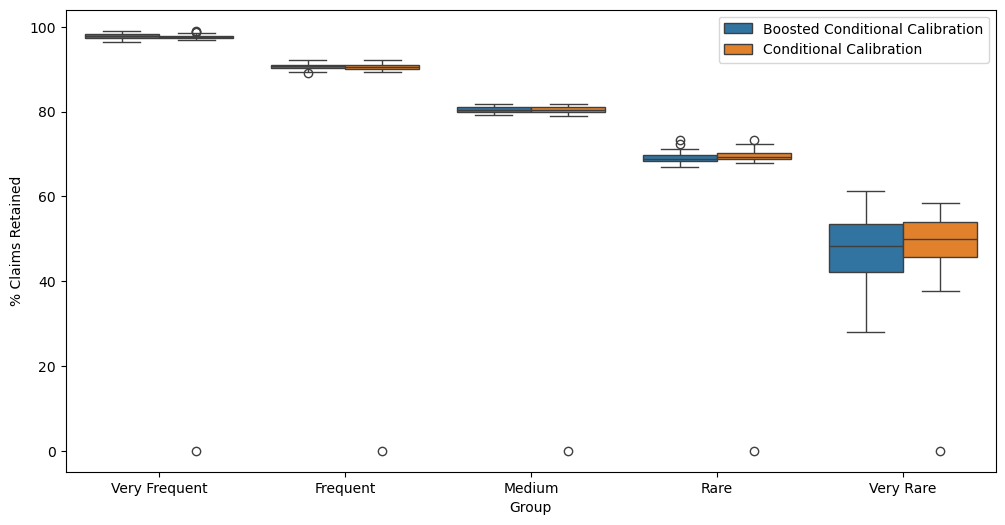

In [457]:
# Create a DataFrame for each method
names = ["Marginal"] + continent_names.tolist() + freq_names.tolist()
indices_to_plot = [-5, -4, -3, -2, -1]

names = [names[i] for i in indices_to_plot]
df1 = pd.DataFrame(all_claims_jc[:,indices_to_plot] * 100, columns=names)
df2 = pd.DataFrame(all_claims[:,indices_to_plot] * 100, columns=names)

# Add a column to identify the method
df1['Method'] = 'Boosted Conditional Calibration'
df2['Method'] = 'Conditional Calibration'

# Combine the DataFrames
df = pd.concat([df1, df2])

# Melt the combined DataFrame
df_melted = df.melt(id_vars='Method', var_name='Group', value_name='% Claims Retained')

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Group', y='% Claims Retained', hue='Method', data=df_melted)
# Customize the plot
plt.legend()

print(np.mean(all_claims_jc[:,0]), np.mean(all_claims[:,0]))

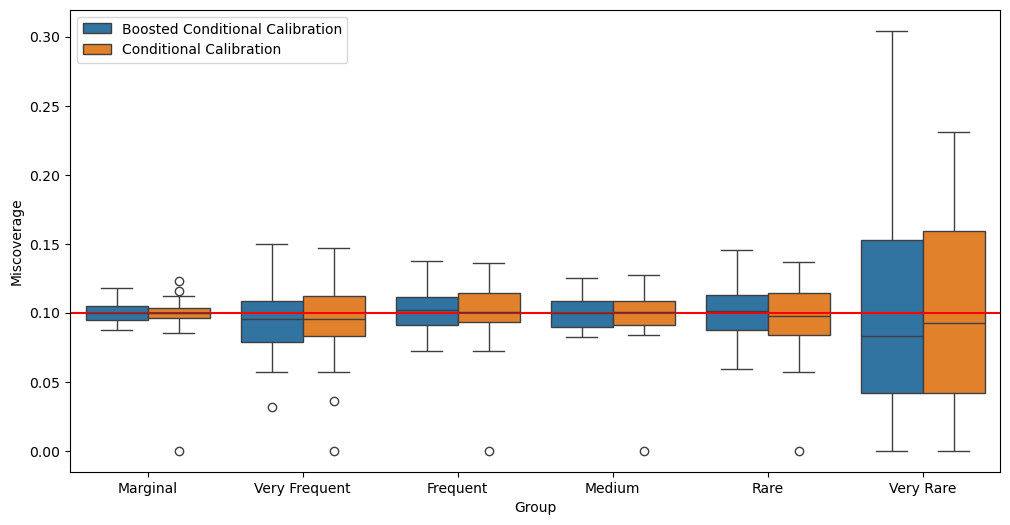

In [448]:
# Create a DataFrame for each method
names = ["Marginal"] + continent_names.tolist() + freq_names.tolist()
indices_to_plot = [0, -5, -4, -3, -2, -1]

names = [names[i] for i in indices_to_plot]
df1 = pd.DataFrame(1 - all_covs_jc[:,indices_to_plot], columns=names)
df2 = pd.DataFrame(1 - all_covs[:,indices_to_plot], columns=names)

# Add a column to identify the method
df1['Method'] = 'Boosted Conditional Calibration'
df2['Method'] = 'Conditional Calibration'

# Combine the DataFrames
df = pd.concat([df1, df2])

# Melt the combined DataFrame
df_melted = df.melt(id_vars='Method', var_name='Group', value_name='Miscoverage')

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Group', y='Miscoverage', hue='Method', data=df_melted)
plt.axhline(0.1, color='red')
# Customize the plot
plt.legend()